# Univariate analysis of 2D <span style="color:#b18bbb">landmark</span> data in <span style="color:#86a7ca">R</span>

**This notebook**...
* ... provides an overview of two-sample hypothesis testing of 2D landmark data in [R](https://www.r-project.org)
* ... explains the details of script `landmarks_uv.R` which appears in this repository
* ... is limited to univariate analysis, via Procrustes ANOVA
* ... is directed at novice R users, who may be using R for the first time.
* ... is likely not useful for intermediate or advanced R users; please refer isntead to the scripts in `./lmfree2d/R/`

**Dependencies**:
* [geomorph](https://github.com/geomorphR/geomorph)

The `geomorph` functions used in this notebook are listed below. Refer to the `geomorph` documentation for details regarding each function. 
* `gpagen`
* `geomorph.data.frame`
* `procD.lm`

___
## Install software

1. First [download and install R](https://cran.ism.ac.jp)
1. Launch R, then install the `geomorph` package by entering the following command into the R Console: `install.packages("geomorph")`


___
## Prepare the workspace

Ensure that you have loaded the `geomorph` library into the workspace using the command below. This can be done in the interactive R Console, or in a script.

In [1]:
library("geomorph")

Loading required package: RRPP

Loading required package: rgl



___
## Load landmark data

Let's load the landmarks CSV file for the Bell dataset, which is located in the `Data` directory of this repository.

In [2]:
dirREPO <- normalizePath("..")
name    <- "Bell"
fname0  <- file.path(dirREPO, "Data", name, "landmarks.csv")
df      <- read.csv(fname0)   # 4 columns: shape, landmark, x, y

Notes:

* `dirREPO` is the repository's directory (i.e., where the repository is saved on your computer); since `dirREPO` is generally different on different computers, it is referred to generically in this notebook as `./lmfree2d/`
* `name` is the dataset name
* `fname0` is the CSV file name, in this case: `./lmfree2d/Data/Bell/landmarks.csv`
* `df` is a dataframe containing the contents of the landmarks CSV file

Let's check the contents of `df`. We'll check just the first 20 rows for brevity.

In [3]:
print(df[1:20,,])

   Shape Landmark     X     Y
1      1        1 0.444 0.000
2      1        2 0.000 0.148
3      1        3 0.194 0.704
4      1        4 0.315 0.991
5      1        5 0.398 1.000
6      1        6 0.481 0.991
7      1        7 0.639 0.704
8      1        8 0.870 0.176
9      2        1 0.367 0.000
10     2        2 0.000 0.156
11     2        3 0.184 0.694
12     2        4 0.238 0.925
13     2        5 0.374 1.000
14     2        6 0.524 0.912
15     2        7 0.585 0.701
16     2        8 0.742 0.156
17     3        1 0.435 0.000
18     3        2 0.000 0.194
19     3        3 0.250 0.722
20     3        4 0.389 0.981


The data frame `df`, like the CSV file itself, contains four columns:

* `Shape`: integer labels that identify shapes. There are 10 shapes in total.
* `Landmark`: integer labels that identify landmarks. There are 8 landmarks in total.
* `X` and `Y`: the 2D coordinates of the landmark points

Let's plot the landmark data:

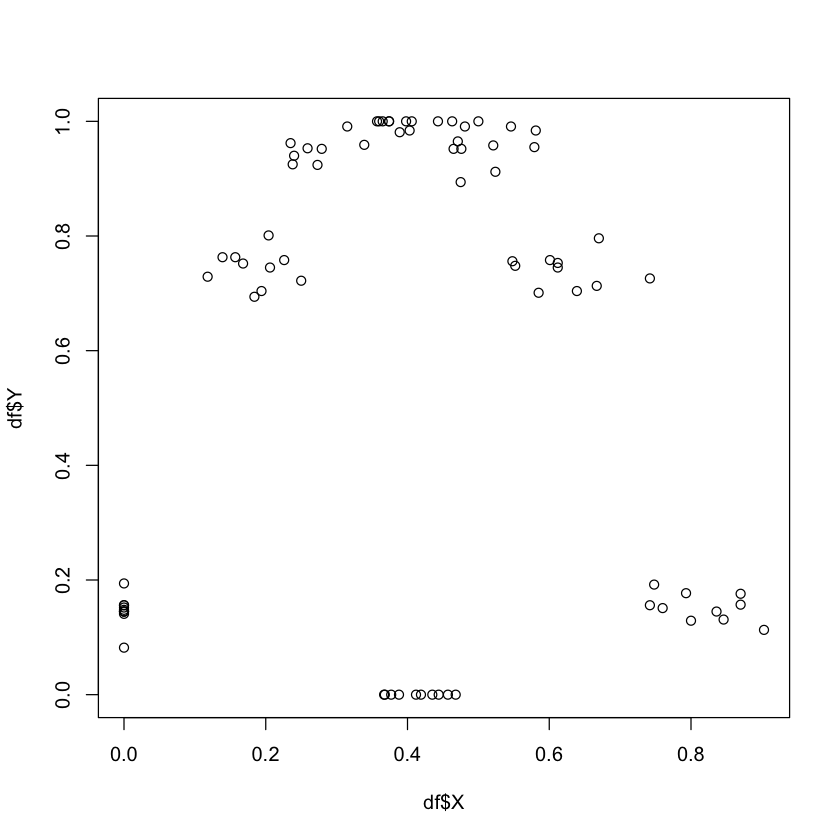

In [4]:
plot( df$X, df$Y )

In the figure above the shapes are somewhat difficult to discern because the shapes are not yet spatially aligned. We can see the overall shape a little more clearly by plotting just one shape: 

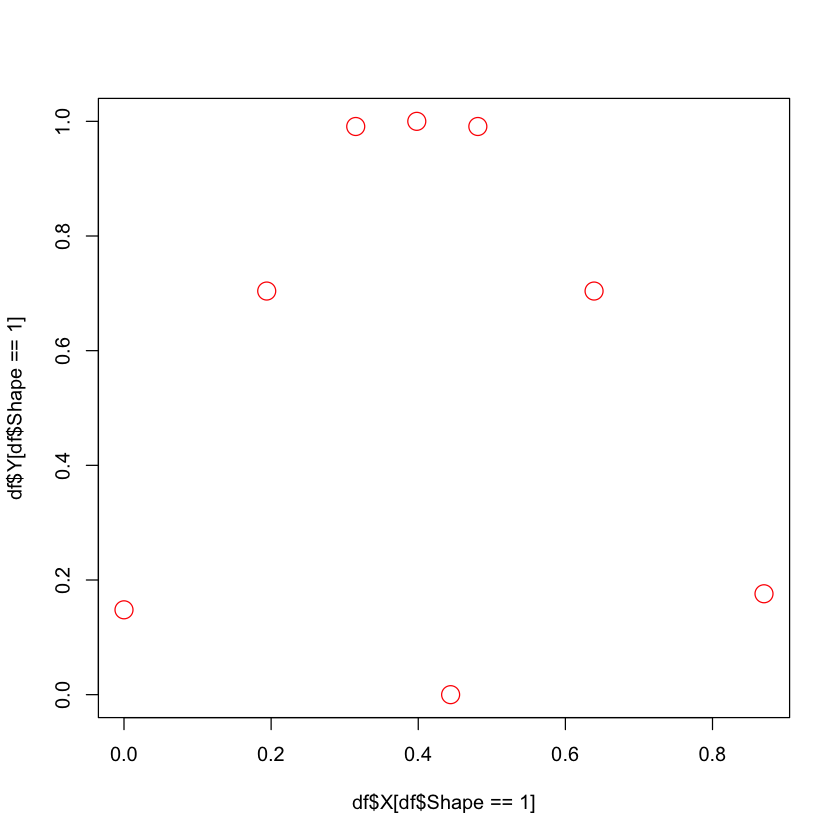

In [5]:
plot( df$X[ df$Shape==1 ], df$Y[ df$Shape==1 ] , col="red", cex=2)

___

## Conduct GPA to spatially align the landmarks

Generalized Procrustes Analysis (GPA) can be used to spatially align a set of homologous landmarks. The `gpagen` function from `geomorph` can be used for this purpose.

In order to use `gpagen`, the data must be arranged in a three-dimensional ($m$ x $n$ x $p$) array, where:
* $m$ = number of landmarks
* $n$ = number of spatial dimensions
* $p$ = number of shapes

In this notebook's example, the values are: $m$=8, $n$=2, and $p$=10.

The 3D array construction can be done in R as follows:

In [6]:
nshapes    <- max( df$Shape )           # number of shapes
nlandmarks <- max( df$Landmark )        # number of landmarks
A          <- as.vector( t(df[,3:4]) )  # flatten the X and Y columns into a vector
dim(A)     <- c(2,nlandmarks,nshapes)   # set the array dimensions
A          <- aperm(A, c(2,1,3) )       # permute the dimensions into the required form: (m, n, p)

print( dim(A) )

[1]  8  2 10


Note that the dimensions of the `A` array are as required.

Let's check that we have constructed `A` correctly, by checking the first two shapes' landmark coordinates:

In [7]:
print( A[,,1] )

      [,1]  [,2]
[1,] 0.444 0.000
[2,] 0.000 0.148
[3,] 0.194 0.704
[4,] 0.315 0.991
[5,] 0.398 1.000
[6,] 0.481 0.991
[7,] 0.639 0.704
[8,] 0.870 0.176


In [8]:
print( A[,,2] )

      [,1]  [,2]
[1,] 0.367 0.000
[2,] 0.000 0.156
[3,] 0.184 0.694
[4,] 0.238 0.925
[5,] 0.374 1.000
[6,] 0.524 0.912
[7,] 0.585 0.701
[8,] 0.742 0.156


Note that these XY coordinates are the same as appear in the CSV file, showing that we have correctly constructed `A`.

We are now ready to spatially align the landmarks using `gpagen`:

  |======================================================================| 100%


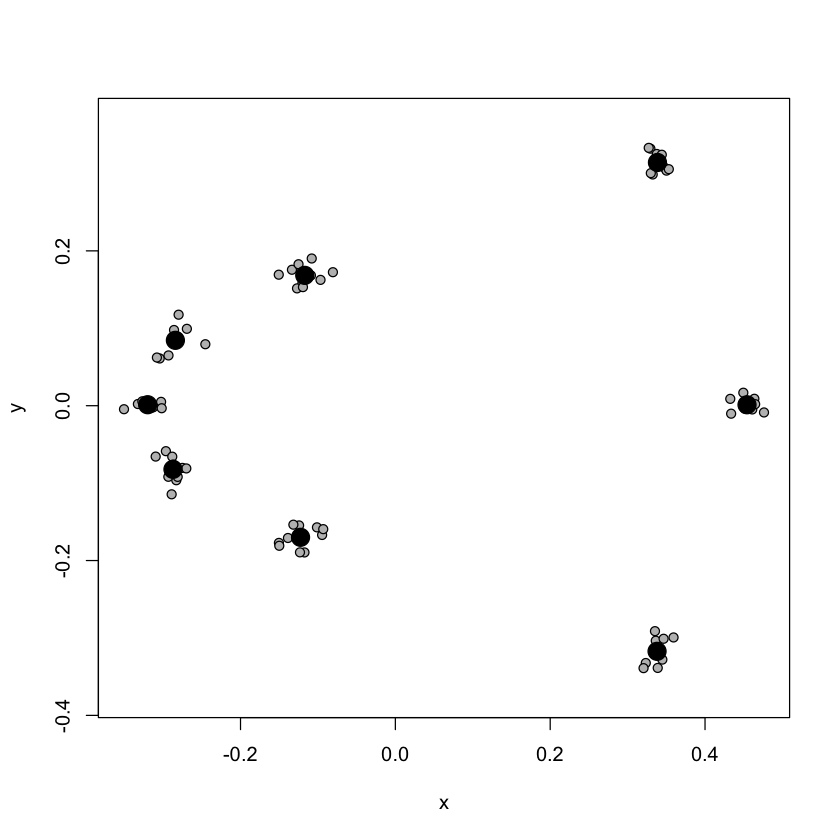

In [9]:
A.gpa <- gpagen(A)
plot( A.gpa )

Now the overall shape is clearer, and individual landmarks (gray dots) form tighter clusters around each mean landmark location (black dots).

The geometry has been rotated, but we can optionally rotate the GPA results using the `rotate.coords` function like this:

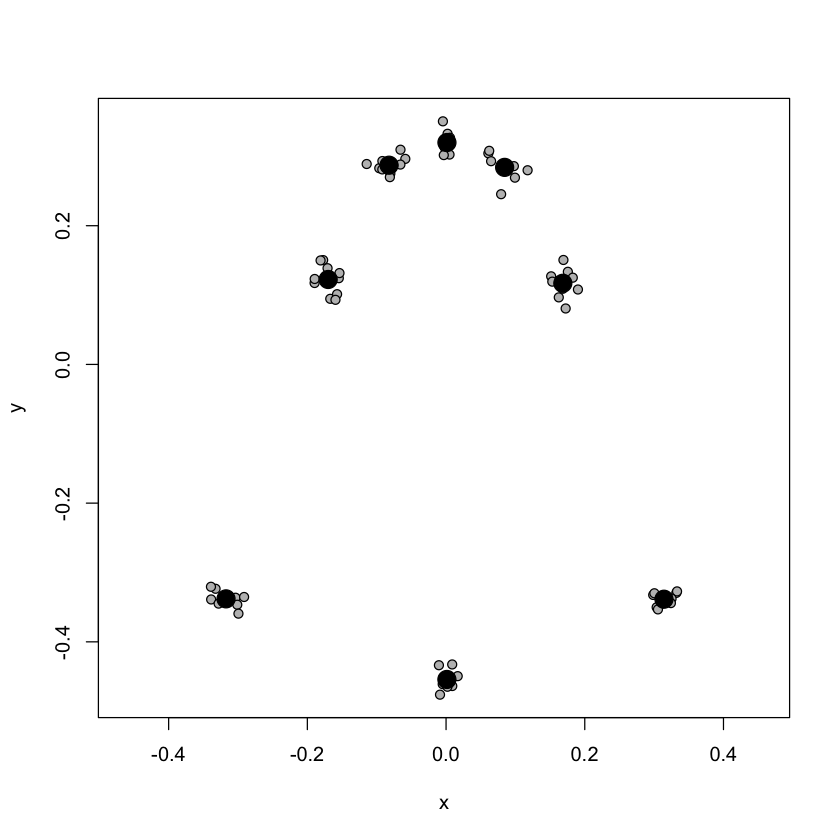

In [10]:
A.gpa <- rotate.coords(A.gpa, "rotateC")
plot(A.gpa)

___
## Conduct hypothesis test

In order to conduct hypothesis, we first need to construct a `group` vector, which contains integers that identify groups. For this dataset, the first 5 shapes belong to one group, and the last 5 shapes belong to a separate group, so we can specify `group` as follows:

In [11]:
group <- factor( c(0,0,0,0,0, 1,1,1,1,1) )

We next need to create a `geomorph` data frame, which requires both (i) the output of the GPA analysis above, and (ii) our group label vector:

In [12]:
gdf <- geomorph.data.frame(A.gpa, group=group)

Last we can conduct univariate analysis using Procrustes ANOVA, which tests the between- vs. within-group variation of the Procrustes distances between shapes. This can be done using the `procD.lm` and `summary` commands as follows:

In [13]:
fit  <- procD.lm(coords ~ group, data = gdf, iter = 1000, RRPP = FALSE, print.progress = FALSE) 
summ <- summary(fit)
print(summ)


Analysis of Variance, using Residual Randomization
Permutation procedure: Randomization of raw values (residuals of mean) 
Number of permutations: 1001 
Estimation method: Ordinary Least Squares 
Sums of Squares and Cross-products: Type I 
Effect sizes (Z) based on F distributions

          Df        SS        MS     Rsq      F      Z Pr(>F)
group      1 0.0060744 0.0060744 0.19825 1.9781 1.2942 0.1329
Residuals  8 0.0245663 0.0030708 0.80175                     
Total      9 0.0306408                                       

Call: procD.lm(f1 = coords ~ group, iter = 1000, RRPP = FALSE, data = gdf,  
    print.progress = FALSE)


In this case the F statistic is 1.978, and the p value is 0.133, implying that the null hypothesis is not rejected, where the null hypothsis is: equivalent mean group shapes.

For details regarding Procrustes ANOVA options, refer to `procD.lm`'s [documentation](http://search.r-project.org/library/geomorph/html/procD.lm.html).